# Bayesian Neural Network with MC-Dropout
**Objective:** Implement uncertainty estimation using Keras

## 1. Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, Input

%matplotlib inline

tf.random.set_seed(42)
np.random.seed(42)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress non-error messages

## 2. Generate Synthetic Data
True function: $y = x + 0.3\sin(4πx) + \epsilon$, $\epsilon \sim \mathcal{N}(0, 0.1)$

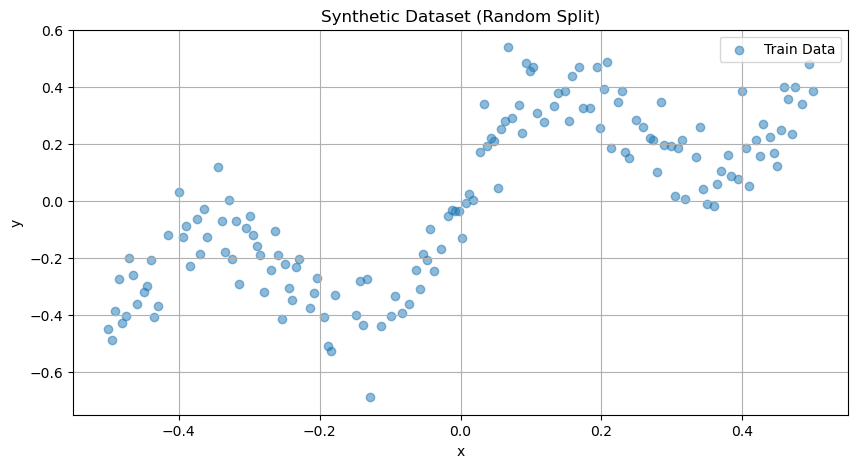

In [2]:
# Generate synthetic data
x = np.linspace(-0.5, 0.5, 200)
y = x + 0.3 * np.sin(4 * np.pi * x) + np.random.normal(0, 0.1, x.shape)

# Reshape x for compatibility with sklearn
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)


# Randomly split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Visualize training data
plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, alpha=0.5, label='Train Data')
plt.title("Synthetic Dataset (Random Split)")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


## 3. Build Bayesian Neural Network
Architecture: 3 hidden layers with Dropout

In [3]:

def build_model(dropout_rate=0.2):
    inputs = Input(shape=(1,))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model


## 4. MC-Dropout Prediction Function
**Key Feature:** Keep dropout active during inference

In [4]:
def mc_dropout_prediction(model, X, num_samples=100):
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)

    # Collect predictions with dropout active
    predictions = np.array([
        model(X, training=True).numpy().squeeze() #Use model(X, training=True) instead of model.predict() to keep dropout active during inference
        for _ in range(num_samples)
    ])
    
    return predictions.T  # Shape: (num_points, num_samples)


## 5. Training and Evaluation

In [5]:
# Train model
model = build_model(dropout_rate=0.2)
history = model.fit(x_train, y_train,
                   epochs=1000,
                   batch_size=32,
                   validation_split=0.2,
                   verbose=0)

# Predictions
x_range = np.linspace(-1, 1, 300)
samples = mc_dropout_prediction(model, x_range, num_samples=200)
pred_mean = samples.mean(axis=1)
pred_std = samples.std(axis=1)

## 6. Visualize Uncertainty Estimation

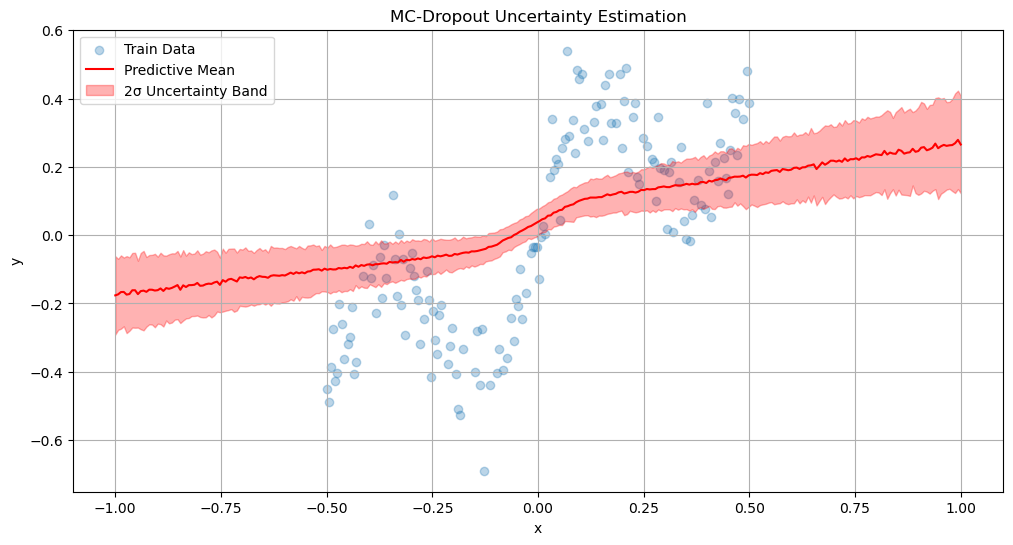

In [7]:
plt.figure(figsize=(12,6))
plt.scatter(x_train, y_train, alpha=0.3, label='Train Data')
plt.plot(x_range, pred_mean, 'r-', label='Predictive Mean')
plt.fill_between(x_range, 
                 pred_mean - 2*pred_std,
                 pred_mean + 2*pred_std,
                 alpha=0.3, color='red', label='2σ Uncertainty Band')

plt.title("MC-Dropout Uncertainty Estimation")
plt.xlabel('x'), plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

## 7. Exercises
1. **Dropout Rate**: Modify `dropout_rate` (0.1, 0.5)
2. **MC Samples**: Change `num_samples` (10 vs 200)
3. **Architecture**: Adjust hidden layers/nodes
4. **Noise Level**: Increase synthetic data noise

**Observation Hints**:
- How does dropout rate affect uncertainty bands?
- Where is uncertainty largest? Why?
- How does model behave outside training range?

## 8. Training History Analysis

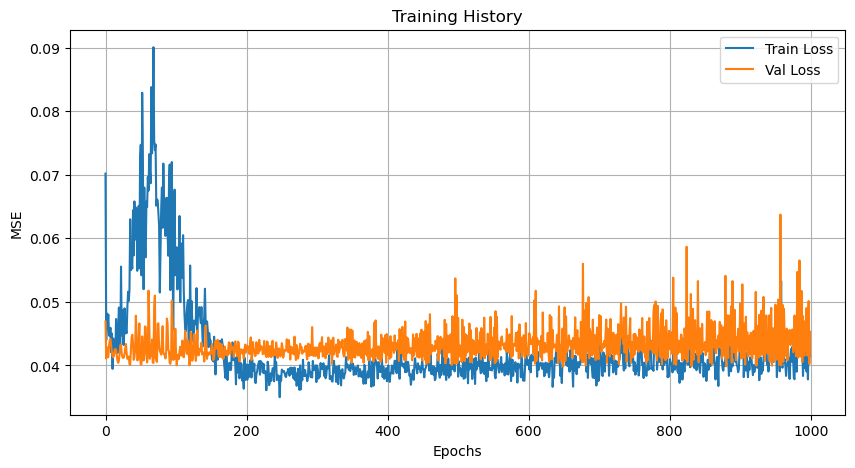

In [8]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training History')
plt.xlabel('Epochs'), plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

## 9. Key Takeaways
- **MC-Dropout Implementation**: Enabled via learning_phase=True in K.function
- **Uncertainty Sources**:
    - Model uncertainty (epistemic): Captured by MC-Dropout
    - Data noise (aleatoric): Should handle via heteroscedastic loss
- **Trade-offs**: Higher dropout rate → higher uncertainty (but less accurate predictions)